#Connect Drive - install mediapipe & YOLO

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mediapipe

In [ ]:
!pip install ultralytics
!pip install pandas
!pip install openpyxl
!pip install opencv-python

#Preprocessing

In [ ]:
import os
import cv2
from albumentations import (
    HorizontalFlip, RandomBrightnessContrast,
    Rotate, MotionBlur, Resize
)
from tqdm import tqdm

# Root dataset input & output
input_root = '/content/drive/MyDrive/Dataset'
output_root = '/content/drive/MyDrive/Dataset_Augmented'    # output path

# Define target resize size
TARGET_SIZE = (640, 640)  # (width, height)

# List of augmentation transformations
transforms = {
    'flip': HorizontalFlip(p=1),
    'brightness': RandomBrightnessContrast(p=1),
    'rotate_plus': Rotate(limit=(0, 15), p=1),
    'rotate_minus': Rotate(limit=(-15, 0), p=1),
    'blur': MotionBlur(p=1)
}

# Resize transformation applied to all images
resize_transform = Resize(height=TARGET_SIZE[1], width=TARGET_SIZE[0], always_apply=True)

# Ensure output folder structure
os.makedirs(output_root, exist_ok=True)

# Loop dataset split: train & test
for split in ['train', 'test']:
    split_input_path = os.path.join(input_root, split)
    split_output_path = os.path.join(output_root, split)
    os.makedirs(split_output_path, exist_ok=True)   # ensure correct path

    # Loop through each class (good, bad back, bad heel)
    for class_name in os.listdir(split_input_path):
        input_folder = os.path.join(split_input_path, class_name)
        if not os.path.isdir(input_folder):
            continue

        output_folder = os.path.join(split_output_path, class_name)
        os.makedirs(output_folder, exist_ok=True)

        # Process all images in the class folder
        for filename in tqdm(os.listdir(input_folder), desc=f"Processing {split}/{class_name}"):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(input_folder, filename)
                image = cv2.imread(image_path)

                if image is None:
                    continue

                # Resize the original image first
                image_resized = resize_transform(image=image)['image']
                base_name = os.path.splitext(filename)[0]

                # Save resized original image
                out_name = f"{base_name}.jpg"
                cv2.imwrite(os.path.join(output_folder, out_name), image_resized)

                # Apply augmentations on the resized image
                for name, transform in transforms.items():
                    augmented = transform(image=image_resized)['image']
                    aug_name = f"{base_name}_{name}.jpg"
                    cv2.imwrite(os.path.join(output_folder, aug_name), augmented)

print("\n Augmentation complete! All files saved at:")
print(f"➡️ {output_root}")

/tmp/ipython-input-111162195.py:26: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  resize_transform = Resize(height=TARGET_SIZE[1], width=TARGET_SIZE[0], always_apply=True)
Processing test/Good: 100%|██████████| 310/310 [00:55<00:00,  5.56it/s]


🎉 Augmentasi selesai! Semua file tersimpan di:
➡️ /content/drive/MyDrive/Dataset_Augmented


##Mediapipe Keypoints

In [ ]:
import cv2
import mediapipe as mp
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

####Mediapipe Train Keypoints

In [ ]:
import os
import cv2
import pandas as pd
from tqdm import tqdm
import mediapipe as mp

# === DATASET AND OUTPUT CONFIGURATION ===
dataset_folder = "/content/drive/MyDrive/Dataset_Augmented/train"
output_excel = "mediapipe_train_landmarks.xlsx"

data_landmarks = []
image_filenames = []
image_classes = []
failed_images = []

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

# === FULL LIST OF 33 MEDIAPIPE KEYPOINT NAMES ===
keypoint_names = [
    "nose", "left_eye_inner", "left_eye", "left_eye_outer",
    "right_eye_inner", "right_eye", "right_eye_outer",
    "left_ear", "right_ear",
    "mouth_left", "mouth_right",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_pinky", "right_pinky",
    "left_index", "right_index", "left_thumb", "right_thumb",
    "left_hip", "right_hip", "left_knee", "right_knee",
    "left_ankle", "right_ankle", "left_heel", "right_heel",
    "left_foot_index", "right_foot_index"
]

# === PROCESS EACH CLASS IN THE DATASET ===
for class_name in os.listdir(dataset_folder):
    class_path = os.path.join(dataset_folder, class_name)

    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

        print(f"\nProcessing class: {class_name} ({len(image_files)} images)")

        for filename in tqdm(image_files, desc=f"Processing {class_name}", ncols=100):
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                failed_images.append(f"{class_name}/{filename} (failed to read)")
                continue

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = pose.process(image_rgb)

            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
                frame_landmarks = []
                for landmark in landmarks:
                    frame_landmarks.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])

                image_filenames.append(filename)
                image_classes.append(class_name)
                data_landmarks.append(frame_landmarks)
            else:
                failed_images.append(f"{class_name}/{filename} (pose not detected)")

# === SAVE DATA TO EXCEL ===
if data_landmarks:
    columns = ["Filename", "Class"] + [
        f"{kp}_{axis}" for kp in keypoint_names for axis in ["x", "y", "z", "visibility"]
    ]

    df = pd.DataFrame(data_landmarks, columns=columns[2:])
    df.insert(0, "Filename", image_filenames)
    df.insert(1, "Class", image_classes)

    # === Save to Google Drive ===
    drive_folder = "/content/drive/MyDrive/Dataset_Excel"
    os.makedirs(drive_folder, exist_ok=True)
    output_drive_path = os.path.join(drive_folder, output_excel)
    df.to_excel(output_drive_path, index=False)
    print(f"📂 File successfully uploaded to Google Drive: {output_drive_path}")
else:
    print("⚠️ No pose detected in the entire dataset.")

# === SUMMARY ===
print("\n=== SUMMARY ===")
print(f"Total successfully processed images: {len(data_landmarks)}")
print(f"Total failed images (undetected / corrupted): {len(failed_images)}")

if failed_images:
    print("\nFailed image list:")
    for f in failed_images[:15]:  # display max 15 to avoid long output
        print(f" - {f}")
    if len(failed_images) > 15:
        print(f"... and {len(failed_images) - 15} more images")


Processing class: Bad Heel (5112 images)


Processing Bad Heel: 100%|██████████████████████████████████████| 5112/5112 [08:06<00:00, 10.51it/s]



Processing class: Good (6006 images)


Processing Good: 100%|██████████████████████████████████████████| 6006/6006 [09:18<00:00, 10.75it/s]



Processing class: .ipynb_checkpoints (0 images)


Processing .ipynb_checkpoints: 0it [00:00, ?it/s]



Processing class: Bad Back (5904 images)


Processing Bad Back: 100%|██████████████████████████████████████| 5904/5904 [09:14<00:00, 10.66it/s]


📂 File berhasil diupload ke Google Drive: /content/drive/MyDrive/Dataset_Excel/mediapipe_train_landmarks.xlsx

=== RINGKASAN HASIL ===
Total gambar berhasil diproses: 16847
Total gambar gagal (tidak terdeteksi / rusak): 175

Daftar gambar gagal:
 - Bad Back/Bad Back (552)_rotate_plus.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (572).jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (572)_rotate_minus.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (572)_blur.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (577).jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (577)_flip.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (577)_rotate_plus.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (549).jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (549)_flip.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (549)_rotate_plus.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (549)_blur.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (594).jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (594

####Mediapipe Test Keypoints

In [ ]:
import os
import cv2
import pandas as pd
from tqdm import tqdm
import mediapipe as mp

# === DATASET AND OUTPUT CONFIGURATION ===
dataset_folder = "/content/drive/MyDrive/Dataset_Augmented/test"
output_excel = "mediapipe_test_landmarks.xlsx"

data_landmarks = []
image_filenames = []
image_classes = []
failed_images = []

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

# === FULL LIST OF 33 MEDIAPIPE KEYPOINT NAMES ===
keypoint_names = [
    "nose", "left_eye_inner", "left_eye", "left_eye_outer",
    "right_eye_inner", "right_eye", "right_eye_outer",
    "left_ear", "right_ear",
    "mouth_left", "mouth_right",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_pinky", "right_pinky",
    "left_index", "right_index", "left_thumb", "right_thumb",
    "left_hip", "right_hip", "left_knee", "right_knee",
    "left_ankle", "right_ankle", "left_heel", "right_heel",
    "left_foot_index", "right_foot_index"
]

# === PROCESS EACH CLASS IN THE DATASET ===
for class_name in os.listdir(dataset_folder):
    class_path = os.path.join(dataset_folder, class_name)

    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

        print(f"\nProcessing class: {class_name} ({len(image_files)} images)")

        for filename in tqdm(image_files, desc=f"Processing {class_name}", ncols=100):
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                failed_images.append(f"{class_name}/{filename} (failed to read)")
                continue

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = pose.process(image_rgb)

            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
                frame_landmarks = []
                for landmark in landmarks:
                    frame_landmarks.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])

                image_filenames.append(filename)
                image_classes.append(class_name)
                data_landmarks.append(frame_landmarks)
            else:
                failed_images.append(f"{class_name}/{filename} (pose not detected)")

# === SAVE DATA TO EXCEL ===
if data_landmarks:
    columns = ["Filename", "Class"] + [
        f"{kp}_{axis}" for kp in keypoint_names for axis in ["x", "y", "z", "visibility"]
    ]

    df = pd.DataFrame(data_landmarks, columns=columns[2:])
    df.insert(0, "Filename", image_filenames)
    df.insert(1, "Class", image_classes)

    # === Save to Google Drive ===
    drive_folder = "/content/drive/MyDrive/Dataset_Excel"
    os.makedirs(drive_folder, exist_ok=True)
    output_drive_path = os.path.join(drive_folder, output_excel)
    df.to_excel(output_drive_path, index=False)
    print(f"📂 File successfully uploaded to Google Drive: {output_drive_path}")
else:
    print("⚠️ No pose detected in the entire dataset.")

# === SUMMARY ===
print("\n=== SUMMARY ===")
print(f"Total successfully processed images: {len(data_landmarks)}")
print(f"Total failed images (undetected / corrupted): {len(failed_images)}")

if failed_images:
    print("\nFailed image list:")
    for f in failed_images[:15]:  # display max 15 to avoid long output
        print(f" - {f}")
    if len(failed_images) > 15:
        print(f"... and {len(failed_images) - 15} more images")


Processing class: .ipynb_checkpoints (0 images)


Processing .ipynb_checkpoints: 0it [00:00, ?it/s]



Processing class: Good (1860 images)


Processing Good: 100%|██████████████████████████████████████████| 1860/1860 [02:53<00:00, 10.73it/s]



Processing class: Bad Back (2028 images)


Processing Bad Back: 100%|██████████████████████████████████████| 2028/2028 [03:14<00:00, 10.41it/s]



Processing class: Bad Heel (1926 images)


Processing Bad Heel: 100%|██████████████████████████████████████| 1926/1926 [03:02<00:00, 10.53it/s]


📂 File berhasil diupload ke Google Drive: /content/drive/MyDrive/Dataset_Excel/mediapipe_test_landmarks.xlsx

=== RINGKASAN HASIL ===
Total gambar berhasil diproses: 5690
Total gambar gagal (tidak terdeteksi / rusak): 124

Daftar gambar gagal:
 - Good/Good (219)_brightness.jpg (tidak terdeteksi pose)
 - Good/Good (305)_blur.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (259)_brightness.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (130)_brightness.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (134)_brightness.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (306)_flip.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (306)_brightness.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (306)_rotate_minus.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (289).jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (289)_brightness.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (289)_rotate_plus.jpg (tidak terdeteksi pose)
 - Bad Back/Bad Back (289)_rotate_minus.jpg (tidak terdeteksi pose

##YOLO Keypoints

####YOLO Train Keyoints

In [ ]:
import os
import pandas as pd
from ultralytics import YOLO
from tqdm import tqdm

# === PATH CONFIGURATION ===
dataset_folder = '/content/drive/MyDrive/Dataset_Augmented/train'
output_excel = 'yolo_train_landmarks.xlsx'

# === INITIALIZE YOLOv8 POSE MODEL ===
model = YOLO('yolov8n-pose.pt')

# === INITIALIZE DATA STORAGE VARIABLES ===
all_data = []
no_pose_detected = []

# === LOOP THROUGH EACH CLASS WITH PROGRESS BAR ===
for class_name in os.listdir(dataset_folder):
    class_path = os.path.join(dataset_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"\nProcessing class: {class_name} ({len(image_files)} images)")

    for filename in tqdm(image_files, desc=f"Processing {class_name}", ncols=100):
        img_path = os.path.join(class_path, filename)
        results = model(img_path, verbose=False)

        keypoints = results[0].keypoints.xy if results and results[0].keypoints else None
        if keypoints is None or len(keypoints) == 0:
            no_pose_detected.append(filename)
            continue

        coords = keypoints[0].cpu().numpy()
        for kp_id, (x, y) in enumerate(coords):
            all_data.append({
                'Filename': filename,
                'Class': class_name,
                'keypoint_id': kp_id,
                'x': x,
                'y': y
            })

# === CONVERT TO LONG DATAFRAME ===
df_long = pd.DataFrame(all_data)

if df_long.empty:
    print("\n⚠️ No pose detected in the entire dataset!")
else:
    # === CONVERT TO WIDE FORMAT ===
    keypoint_names = [
        "nose", "left_eye", "right_eye", "left_ear", "right_ear",
        "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
        "left_wrist", "right_wrist", "left_hip", "right_hip",
        "left_knee", "right_knee", "left_ankle", "right_ankle"
    ]

    df_long['keypoint_name'] = df_long['keypoint_id'].apply(lambda i: keypoint_names[i])

    # Pivot for X and Y
    x_df = df_long.pivot_table(index=['Filename', 'Class'], columns='keypoint_name', values='x', aggfunc='first')
    x_df.columns = [f'{col}_x' for col in x_df.columns]

    y_df = df_long.pivot_table(index=['Filename', 'Class'], columns='keypoint_name', values='y', aggfunc='first')
    y_df.columns = [f'{col}_y' for col in y_df.columns]

    # Combine X and Y tables
    final_df = pd.concat([x_df, y_df], axis=1)

    # Sort columns so X and Y are side-by-side
    sorted_columns = []
    for keypoint in keypoint_names:
        if f'{keypoint}_x' in final_df.columns:
            sorted_columns.append(f'{keypoint}_x')
        if f'{keypoint}_y' in final_df.columns:
            sorted_columns.append(f'{keypoint}_y')

    final_df = final_df[sorted_columns].reset_index()

    # === SAVE EXCEL FILE TO GOOGLE DRIVE ===
    drive_folder = "/content/drive/MyDrive/Dataset_Excel"
    os.makedirs(drive_folder, exist_ok=True)

    output_path = os.path.join(drive_folder, output_excel)
    final_df.to_excel(output_path, index=False)

    print(f"\n📂 File successfully uploaded to Google Drive: {output_path}")

    # === SUMMARY ===
    total_detected = len(final_df)
    print("\n=== SUMMARY ===")
    print(f"Total pose detections: {total_detected}")
    print(f"Total failed detections: {len(no_pose_detected)}")

    if no_pose_detected:
        print("\nFailed images:")
        for name in no_pose_detected[:10]:  # show first 10 examples
            print(f" - {name}")
        if len(no_pose_detected) > 10:
            print(f"... and {len(no_pose_detected) - 10} more")


Processing class: Bad Heel (5112 images)


Processing Bad Heel: 100%|██████████████████████████████████████| 5112/5112 [28:13<00:00,  3.02it/s]



Processing class: Good (6006 images)


Processing Good: 100%|██████████████████████████████████████████| 6006/6006 [33:07<00:00,  3.02it/s]



Processing class: .ipynb_checkpoints (0 images)


Processing .ipynb_checkpoints: 0it [00:00, ?it/s]



Processing class: Bad Back (5904 images)


Processing Bad Back: 100%|██████████████████████████████████████| 5904/5904 [32:17<00:00,  3.05it/s]



✅ Ekstraksi YOLOv8 Pose selesai!
📁 File disimpan di: /content/drive/MyDrive/Dataset_Excel/yolo_train_landmarks.xlsx

📊 Ringkasan hasil deteksi:
  - Jumlah pose terdeteksi: 17022
  - Jumlah gambar gagal deteksi: 0


####YOLO Test Keypoints

In [ ]:
import os
import pandas as pd
from ultralytics import YOLO
from tqdm import tqdm

# === PATH CONFIGURATION ===
dataset_folder = '/content/drive/MyDrive/Dataset_Augmented/test'
output_excel = 'yolo_test_landmarks.xlsx'

# === INITIALIZE YOLOv8 POSE MODEL ===
model = YOLO('yolov8n-pose.pt')

# === INITIALIZE DATA STORAGE VARIABLES ===
all_data = []
no_pose_detected = []

# === LOOP THROUGH EACH CLASS WITH PROGRESS BAR ===
for class_name in os.listdir(dataset_folder):
    class_path = os.path.join(dataset_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"\nProcessing class: {class_name} ({len(image_files)} images)")

    for filename in tqdm(image_files, desc=f"Processing {class_name}", ncols=100):
        img_path = os.path.join(class_path, filename)
        results = model(img_path, verbose=False)

        keypoints = results[0].keypoints.xy if results and results[0].keypoints else None
        if keypoints is None or len(keypoints) == 0:
            no_pose_detected.append(filename)
            continue

        coords = keypoints[0].cpu().numpy()
        for kp_id, (x, y) in enumerate(coords):
            all_data.append({
                'Filename': filename,
                'Class': class_name,
                'keypoint_id': kp_id,
                'x': x,
                'y': y
            })

# === CONVERT TO LONG DATAFRAME ===
df_long = pd.DataFrame(all_data)

if df_long.empty:
    print("\n⚠️ No pose detected in the entire dataset!")
else:
    # === CONVERT TO WIDE FORMAT ===
    keypoint_names = [
        "nose", "left_eye", "right_eye", "left_ear", "right_ear",
        "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
        "left_wrist", "right_wrist", "left_hip", "right_hip",
        "left_knee", "right_knee", "left_ankle", "right_ankle"
    ]

    df_long['keypoint_name'] = df_long['keypoint_id'].apply(lambda i: keypoint_names[i])

    # Pivot for X and Y
    x_df = df_long.pivot_table(index=['Filename', 'Class'], columns='keypoint_name', values='x', aggfunc='first')
    x_df.columns = [f'{col}_x' for col in x_df.columns]

    y_df = df_long.pivot_table(index=['Filename', 'Class'], columns='keypoint_name', values='y', aggfunc='first')
    y_df.columns = [f'{col}_y' for col in y_df.columns]

    # Combine X and Y tables
    final_df = pd.concat([x_df, y_df], axis=1)

    # Sort columns so X and Y are side-by-side
    sorted_columns = []
    for keypoint in keypoint_names:
        if f'{keypoint}_x' in final_df.columns:
            sorted_columns.append(f'{keypoint}_x')
        if f'{keypoint}_y' in final_df.columns:
            sorted_columns.append(f'{keypoint}_y')

    final_df = final_df[sorted_columns].reset_index()

    # === SAVE EXCEL FILE TO GOOGLE DRIVE ===
    drive_folder = "/content/drive/MyDrive/Dataset_Excel"
    os.makedirs(drive_folder, exist_ok=True)

    output_path = os.path.join(drive_folder, output_excel)
    final_df.to_excel(output_path, index=False)

    print(f"\n📂 File successfully uploaded to Google Drive: {output_path}")

    # === SUMMARY ===
    total_detected = len(final_df)
    print("\n=== SUMMARY ===")
    print(f"Total pose detections: {total_detected}")
    print(f"Total failed detections: {len(no_pose_detected)}")

    if no_pose_detected:
        print("\nFailed images:")
        for name in no_pose_detected[:10]:  # show first 10 examples
            print(f" - {name}")
        if len(no_pose_detected) > 10:
            print(f"... and {len(no_pose_detected) - 10} more")



Processing class: .ipynb_checkpoints (0 images)


Processing .ipynb_checkpoints: 0it [00:00, ?it/s]



Processing class: Good (1860 images)


Processing Good: 100%|██████████████████████████████████████████| 1860/1860 [10:01<00:00,  3.09it/s]



Processing class: Bad Back (2028 images)


Processing Bad Back: 100%|██████████████████████████████████████| 2028/2028 [11:03<00:00,  3.06it/s]



Processing class: Bad Heel (1926 images)


Processing Bad Heel: 100%|██████████████████████████████████████| 1926/1926 [10:28<00:00,  3.07it/s]



✅ Ekstraksi YOLOv8 Pose selesai!
📁 File disimpan di: /content/drive/MyDrive/Dataset_Excel/yolo_test_landmarks.xlsx

📊 Ringkasan hasil deteksi:
  - Jumlah pose terdeteksi: 5814
  - Jumlah gambar gagal deteksi: 0


#Calculate Angles

##Mediapipe Angles

In [ ]:
import pandas as pd
import math
import os

# === Function to calculate angle between 3 points ===
def calculate_angle(ax, ay, bx, by, cx, cy):
    ab = [ax - bx, ay - by]
    cb = [cx - bx, cy - by]
    dot_product = ab[0] * cb[0] + ab[1] * cb[1]
    magnitude = math.sqrt(ab[0]**2 + ab[1]**2) * math.sqrt(cb[0]**2 + cb[1]**2)
    if magnitude == 0:
        return None
    angle = math.degrees(math.acos(dot_product / magnitude))
    return round(angle, 2)

# === Main function: convert landmark file into angle file ===
def process_landmark_file(file_path):
    print(f"[INFO] Processing file: {file_path}")

    # Read Excel file
    df = pd.read_excel(file_path)
    df.columns = [col.lower() for col in df.columns]

    # Create output dataframe
    angles = pd.DataFrame()
    angles["Filename"] = df["filename"]
    angles["Class"] = df["class"]

    # === Calculate important angles ===
    angles["left_knee"] = df.apply(lambda r: calculate_angle(
        r["left_hip_x"], r["left_hip_y"],
        r["left_knee_x"], r["left_knee_y"],
        r["left_ankle_x"], r["left_ankle_y"]), axis=1)

    angles["right_knee"] = df.apply(lambda r: calculate_angle(
        r["right_hip_x"], r["right_hip_y"],
        r["right_knee_x"], r["right_knee_y"],
        r["right_ankle_x"], r["right_ankle_y"]), axis=1)

    angles["left_hip"] = df.apply(lambda r: calculate_angle(
        r["left_shoulder_x"], r["left_shoulder_y"],
        r["left_hip_x"], r["left_hip_y"],
        r["left_knee_x"], r["left_knee_y"]), axis=1)

    angles["right_hip"] = df.apply(lambda r: calculate_angle(
        r["right_shoulder_x"], r["right_shoulder_y"],
        r["right_hip_x"], r["right_hip_y"],
        r["right_knee_x"], r["right_knee_y"]), axis=1)

    angles["left_shoulder"] = df.apply(lambda r: calculate_angle(
        r["left_elbow_x"], r["left_elbow_y"],
        r["left_shoulder_x"], r["left_shoulder_y"],
        r["left_hip_x"], r["left_hip_y"]), axis=1)

    angles["right_shoulder"] = df.apply(lambda r: calculate_angle(
        r["right_elbow_x"], r["right_elbow_y"],
        r["right_shoulder_x"], r["right_shoulder_y"],
        r["right_hip_x"], r["right_hip_y"]), axis=1)

    # === Determine output path in the same folder ===
    folder_path = os.path.dirname(file_path)
    base_name = os.path.basename(file_path).replace("_landmarks", "_angles")
    output_path = os.path.join(folder_path, base_name)

    # Save to Excel in the same folder
    angles.to_excel(output_path, index=False)
    print(f"[✓] Angle file saved to: {output_path}")

# === Run for train and test ===
drive_folder = "/content/drive/MyDrive/Dataset_Excel"

process_landmark_file(os.path.join(drive_folder, "mediapipe_train_landmarks.xlsx"))
process_landmark_file(os.path.join(drive_folder, "mediapipe_test_landmarks.xlsx"))

[INFO] Memproses file: /content/drive/MyDrive/Dataset_Excel/mediapipe_train_landmarks.xlsx
[✓] Hasil sudut disimpan ke: /content/drive/MyDrive/Dataset_Excel/mediapipe_train_angles.xlsx
[INFO] Memproses file: /content/drive/MyDrive/Dataset_Excel/mediapipe_test_landmarks.xlsx
[✓] Hasil sudut disimpan ke: /content/drive/MyDrive/Dataset_Excel/mediapipe_test_angles.xlsx


##YOLO Angles

In [ ]:
import pandas as pd
import math
import os

# === Function to calculate angle between 3 points ===
def calculate_angle(ax, ay, bx, by, cx, cy):
    ab = [ax - bx, ay - by]
    cb = [cx - bx, cy - by]
    dot_product = ab[0] * cb[0] + ab[1] * cb[1]
    magnitude = math.sqrt(ab[0]**2 + ab[1]**2) * math.sqrt(cb[0]**2 + cb[1]**2)
    if magnitude == 0:
        return None
    angle = math.degrees(math.acos(dot_product / magnitude))
    return round(angle, 2)

# === Main function to process YOLO landmark file ===
def process_yolo_file(file_path, output_name):
    print(f"[INFO] Processing file: {os.path.basename(file_path)}")
    df = pd.read_excel(file_path)
    df.columns = [col.lower() for col in df.columns]

    # === Create output dataframe ===
    angles = pd.DataFrame()
    angles["Filename"] = df["filename"]
    angles["Class"] = df["class"]

    # === Calculate important angles ===
    angles["left_knee"] = df.apply(lambda row: calculate_angle(
        row["left_hip_x"], row["left_hip_y"],
        row["left_knee_x"], row["left_knee_y"],
        row["left_ankle_x"], row["left_ankle_y"]
    ), axis=1)

    angles["right_knee"] = df.apply(lambda row: calculate_angle(
        row["right_hip_x"], row["right_hip_y"],
        row["right_knee_x"], row["right_knee_y"],
        row["right_ankle_x"], row["right_ankle_y"]
    ), axis=1)

    angles["left_hip"] = df.apply(lambda row: calculate_angle(
        row["left_shoulder_x"], row["left_shoulder_y"],
        row["left_hip_x"], row["left_hip_y"],
        row["left_knee_x"], row["left_knee_y"]
    ), axis=1)

    angles["right_hip"] = df.apply(lambda row: calculate_angle(
        row["right_shoulder_x"], row["right_shoulder_y"],
        row["right_hip_x"], row["right_hip_y"],
        row["right_knee_x"], row["right_knee_y"]
    ), axis=1)

    angles["left_shoulder"] = df.apply(lambda row: calculate_angle(
        row["left_elbow_x"], row["left_elbow_y"],
        row["left_shoulder_x"], row["left_shoulder_y"],
        row["left_hip_x"], row["left_hip_y"]
    ), axis=1)

    angles["right_shoulder"] = df.apply(lambda row: calculate_angle(
        row["right_elbow_x"], row["right_elbow_y"],
        row["right_shoulder_x"], row["right_shoulder_y"],
        row["right_hip_x"], row["right_hip_y"]
    ), axis=1)

    # === Save output in the same directory ===
    output_file = os.path.join(os.path.dirname(file_path), output_name)
    angles.to_excel(output_file, index=False)
    print(f"[✓] Angle file saved to: {output_file}\n")

# === YOLOv8 landmark file paths ===
base_path = "/content/drive/MyDrive/Dataset_Excel"  # Adjust to your folder location
train_file = os.path.join(base_path, "yolo_train_landmarks.xlsx")
test_file = os.path.join(base_path, "yolo_test_landmarks.xlsx")

# === Run for train and test ===
process_yolo_file(train_file, "yolo_train_angles.xlsx")
process_yolo_file(test_file, "yolo_test_angles.xlsx")

[INFO] Memproses file: yolo_train_landmarks.xlsx
[✓] Hasil sudut disimpan ke: /content/drive/MyDrive/Dataset_Excel/yolo_train_angles.xlsx

[INFO] Memproses file: yolo_test_landmarks.xlsx
[✓] Hasil sudut disimpan ke: /content/drive/MyDrive/Dataset_Excel/yolo_test_angles.xlsx



#SMOTE


[INFO] Memproses file: mediapipe_train_landmarks.xlsx


/tmp/ipython-input-437831514.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_df["Class"] = y_res
/tmp/ipython-input-437831514.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_df["is_synthetic"] = 1


[✓] File berhasil dioverride: /content/drive/MyDrive/Dataset_Excel/mediapipe_train_landmarks.xlsx


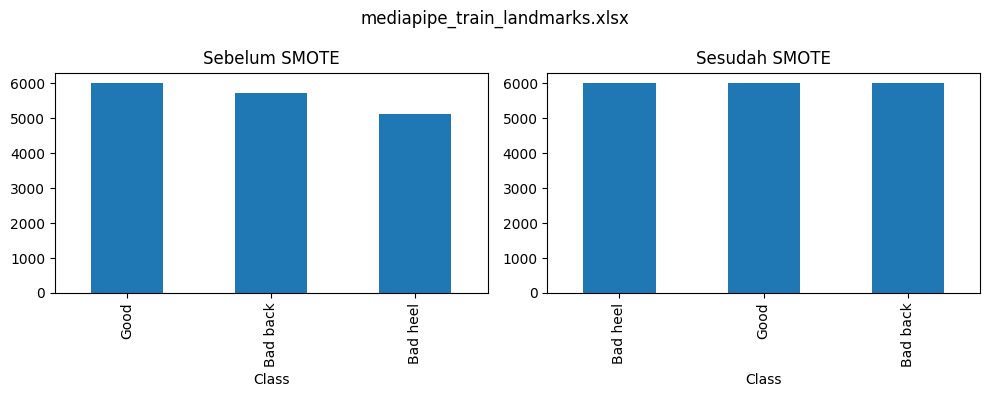


[INFO] Memproses file: mediapipe_test_landmarks.xlsx


/tmp/ipython-input-437831514.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_df["Class"] = y_res
/tmp/ipython-input-437831514.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_df["is_synthetic"] = 1


[✓] File berhasil dioverride: /content/drive/MyDrive/Dataset_Excel/mediapipe_test_landmarks.xlsx


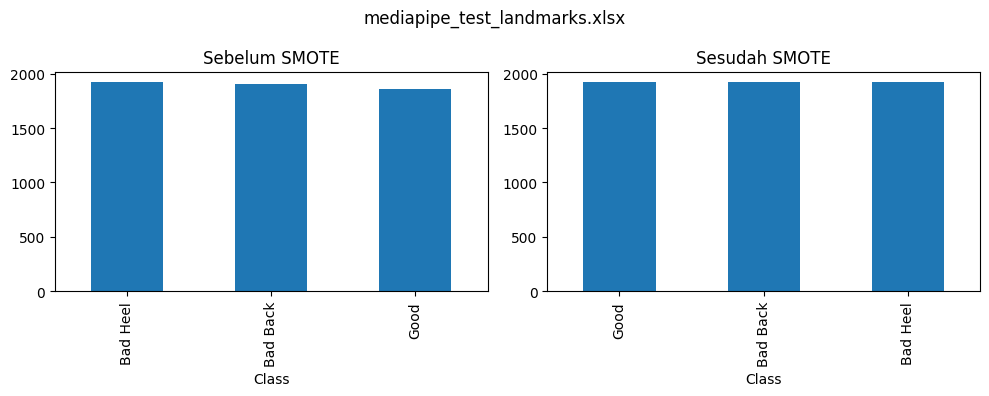


[INFO] Memproses file: mediapipe_train_angles.xlsx
[✓] File berhasil dioverride: /content/drive/MyDrive/Dataset_Excel/mediapipe_train_angles.xlsx


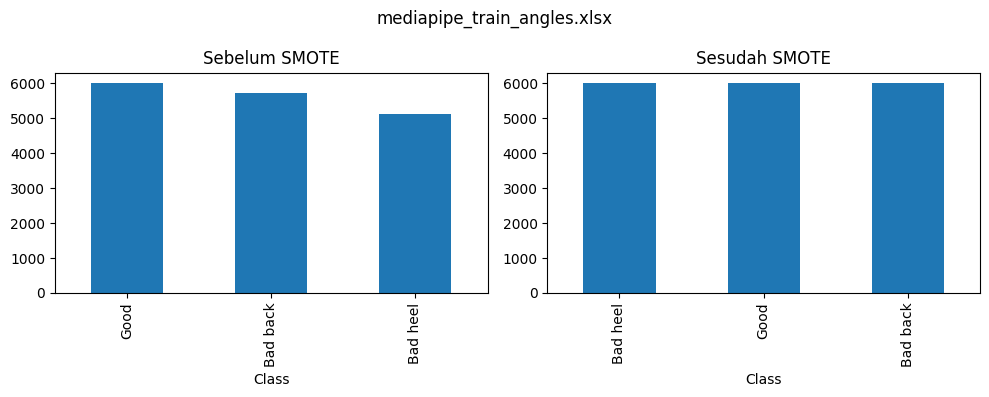


[INFO] Memproses file: mediapipe_test_angles.xlsx
[✓] File berhasil dioverride: /content/drive/MyDrive/Dataset_Excel/mediapipe_test_angles.xlsx


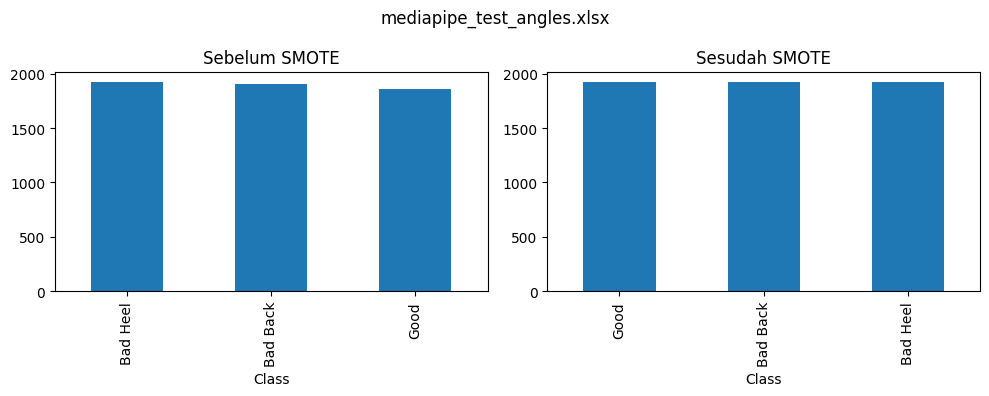


[INFO] Memproses file: yolo_train_landmarks.xlsx
[✓] File berhasil dioverride: /content/drive/MyDrive/Dataset_Excel/yolo_train_landmarks.xlsx


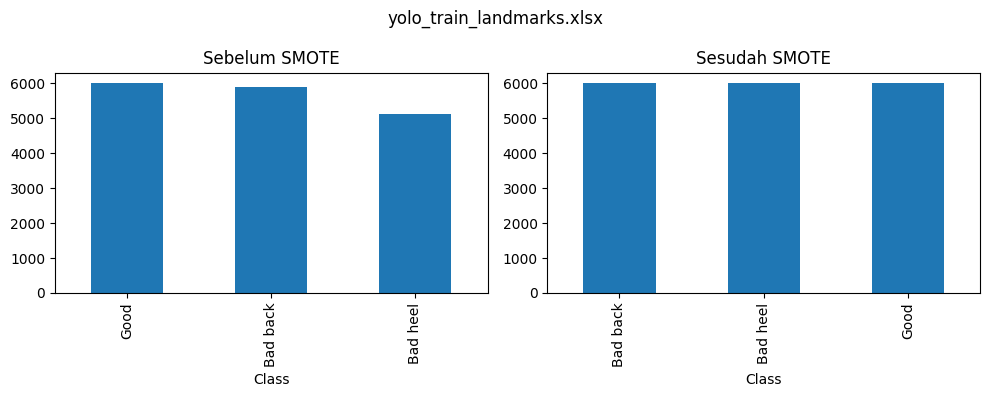


[INFO] Memproses file: yolo_test_landmarks.xlsx
[✓] File berhasil dioverride: /content/drive/MyDrive/Dataset_Excel/yolo_test_landmarks.xlsx


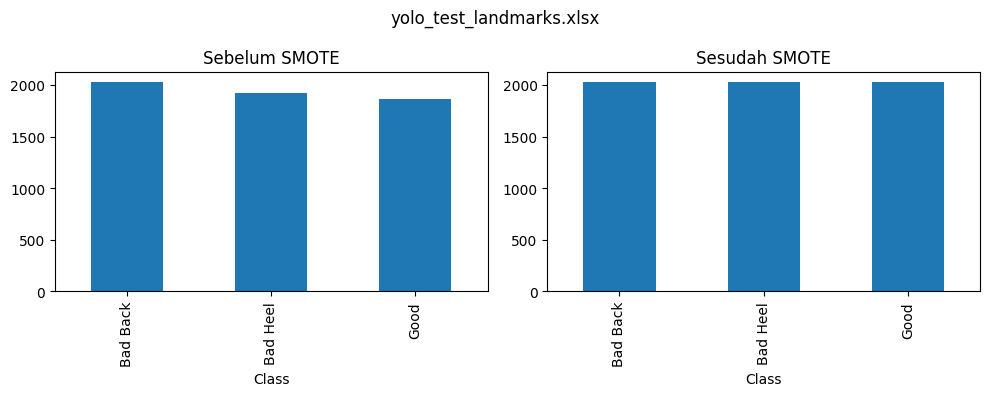


[INFO] Memproses file: yolo_train_angles.xlsx
[✓] File berhasil dioverride: /content/drive/MyDrive/Dataset_Excel/yolo_train_angles.xlsx


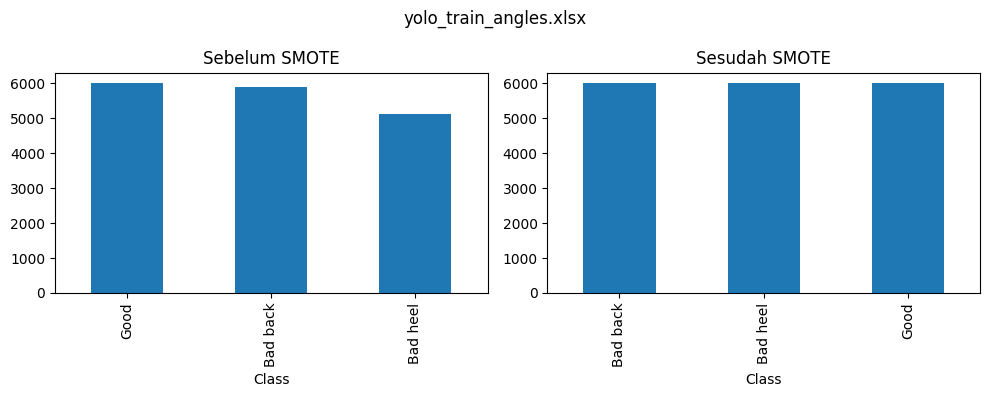


[INFO] Memproses file: yolo_test_angles.xlsx
[✓] File berhasil dioverride: /content/drive/MyDrive/Dataset_Excel/yolo_test_angles.xlsx


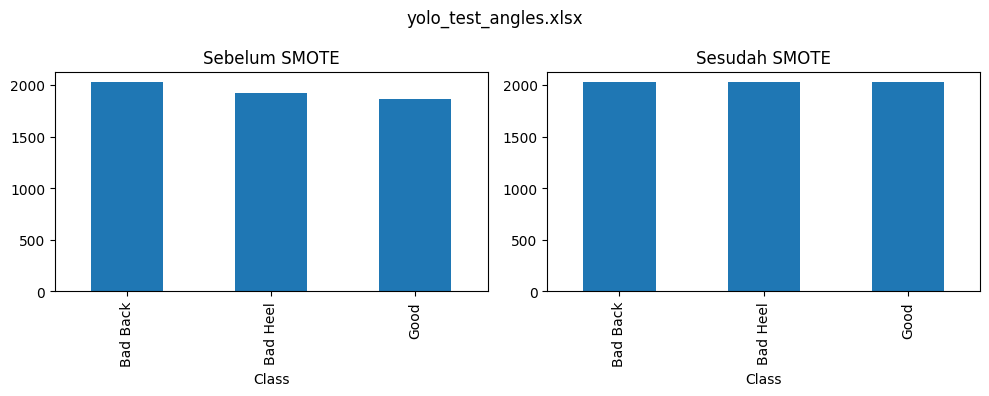


[✓] Semua file berhasil dioverride dengan hasil SMOTE!


In [ ]:
import os
import pandas as pd
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# === 1. Folder location for datasets in Google Drive ===
base_path = "/content/drive/MyDrive/Dataset_Excel"

# === 2. List of all Excel files to be processed ===
files_to_smote = [
    "mediapipe_train_landmarks.xlsx",
    "mediapipe_test_landmarks.xlsx",
    "mediapipe_train_angles.xlsx",
    "mediapipe_test_angles.xlsx",
    "yolo_train_landmarks.xlsx",
    "yolo_test_landmarks.xlsx",
    "yolo_train_angles.xlsx",
    "yolo_test_angles.xlsx",
]

# === 3. SMOTE function for a single file ===
def apply_smote(file_path):
    print(f"\n[INFO] Processing file: {os.path.basename(file_path)}")

    # --- Check if file exists ---
    if not os.path.exists(file_path):
        print(f"[WARNING] File not found: {file_path}")
        return

    # --- 1. Read Excel file ---
    df = pd.read_excel(file_path)

    # --- Ensure required columns exist ---
    if "Class" not in df.columns or "Filename" not in df.columns:
        print(f"[SKIP] Column 'Class' or 'Filename' not found. Skipped.")
        return

    # --- 2. Separate features and labels ---
    X = df.drop(columns=["Filename", "Class"], errors="ignore")
    y = df["Class"]

    # --- 3. Store original data with indicator ---
    original_df = df.copy()
    original_df["is_synthetic"] = 0

    # --- 4. Apply SMOTE ---
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    # --- 5. Create SMOTE result dataframe ---
    resampled_df = pd.DataFrame(X_res, columns=X.columns)
    resampled_df["Class"] = y_res
    resampled_df["is_synthetic"] = 1

    # --- 6. Extract only additional synthetic rows ---
    synthetic_df = resampled_df.iloc[len(original_df):].reset_index(drop=True)

    # --- 7. Generate new filenames for synthetic samples ---
    synthetic_df["Filename"] = [
        f"{label}_SMOTE_{i+1:04d}.jpg" for i, label in enumerate(synthetic_df["Class"])
    ]

    # --- 8. Combine original + synthetic data ---
    final_df = pd.concat([original_df, synthetic_df], ignore_index=True)

    # --- 9. Save results to the same file (OVERRIDE) ---
    final_df.to_excel(file_path, index=False)
    print(f"[✓] File successfully overridden: {file_path}")

    # --- 10. Class distribution visualization (optional) ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    y.value_counts().plot(kind="bar", ax=axes[0], title="Before SMOTE")
    y_res.value_counts().plot(kind="bar", ax=axes[1], title="After SMOTE")
    plt.suptitle(os.path.basename(file_path))
    plt.tight_layout()
    plt.show()

# === 4. Run SMOTE for all files ===
for fname in files_to_smote:
    fpath = os.path.join(base_path, fname)
    apply_smote(fpath)

print("\n[✓] All files successfully overridden with SMOTE results!")

#TRAINING

##Random Forest

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def RandomForest(train, test):
    train_file = train
    test_file = test

    # --- Load data ---
    train_df = pd.read_excel(train_file)
    test_df = pd.read_excel(test_file)

    # --- Split features and labels ---
    X_train = train_df.drop(columns=["Filename", "Class"])
    y_train = train_df["Class"]

    X_test = test_df.drop(columns=["Filename", "Class"])
    y_test = test_df["Class"]

    # --- Create and train Random Forest model ---
    model = RandomForestClassifier(
        n_estimators=100,
        random_state=42
    )
    model.fit(X_train, y_train)

    # --- Predict on test data ---
    y_pred = model.predict(X_test)

    # --- Evaluate results ---
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy on test data: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

####Mediapipe Keypoints

In [3]:
RandomForest("/content/drive/MyDrive/Dataset_Excel/mediapipe_train_landmarks_SMOTE.xlsx", "/content/drive/MyDrive/Dataset_Excel/mediapipe_test_landmarks_SMOTE.xlsx")

Accuracy on test data: 0.9078

Classification Report:
              precision    recall  f1-score   support

    Bad Back       0.96      0.88      0.91      1923
    Bad Heel       0.96      0.90      0.93      1923
        Good       0.82      0.95      0.88      1923

    accuracy                           0.91      5769
   macro avg       0.91      0.91      0.91      5769
weighted avg       0.91      0.91      0.91      5769



####Mediapipe Angles

In [ ]:
RandomForest("/content/drive/MyDrive/Dataset_Excel/mediapipe_train_angles_SMOTE.xlsx", "/content/drive/MyDrive/Dataset_Excel/mediapipe_test_angles_SMOTE.xlsx")

Akurasi pada data test: 0.7861

Classification Report:
              precision    recall  f1-score   support

    Bad Back       1.00      0.76      0.87      1923
    Bad Heel       0.79      0.79      0.79      1923
        Good       0.65      0.80      0.72      1923

    accuracy                           0.79      5769
   macro avg       0.81      0.79      0.79      5769
weighted avg       0.81      0.79      0.79      5769



####YOLO Keypoints

In [ ]:
RandomForest("/content/drive/MyDrive/Dataset_Excel/yolo_train_landmarks_SMOTE.xlsx", "/content/drive/MyDrive/Dataset_Excel/yolo_test_landmarks_SMOTE.xlsx")

Akurasi pada data test: 0.9075

Classification Report:
              precision    recall  f1-score   support

    Bad Back       0.93      0.87      0.90      2028
    Bad Heel       0.93      0.93      0.93      2028
        Good       0.86      0.92      0.89      2028

    accuracy                           0.91      6084
   macro avg       0.91      0.91      0.91      6084
weighted avg       0.91      0.91      0.91      6084



####YOLO Angles

In [ ]:
RandomForest("/content/drive/MyDrive/Dataset_Excel/yolo_train_angles_SMOTE.xlsx", "/content/drive/MyDrive/Dataset_Excel/yolo_test_angles_SMOTE.xlsx")

Akurasi pada data test: 0.7378

Classification Report:
              precision    recall  f1-score   support

    Bad Back       1.00      0.89      0.94      2028
    Bad Heel       0.66      0.66      0.66      2028
        Good       0.60      0.66      0.63      2028

    accuracy                           0.74      6084
   macro avg       0.75      0.74      0.74      6084
weighted avg       0.75      0.74      0.74      6084



##Light GBM

In [ ]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

def LightGBM(train, test):
    train_file = train
    test_file = test

    # --- Load data ---
    train_df = pd.read_excel(train_file)
    test_df = pd.read_excel(test_file)

    # --- Split features and labels ---
    X_train = train_df.drop(columns=["Filename", "Class"])
    y_train = train_df["Class"]

    X_test = test_df.drop(columns=["Filename", "Class"])
    y_test = test_df["Class"]

    # --- Create and train LightGBM model ---
    model = LGBMClassifier(
        n_estimators=200,       # number of trees
        learning_rate=0.05,    # learning rate
        max_depth=-1,          # auto depth
        random_state=42
    )
    model.fit(X_train, y_train)

    # --- Predict on test data ---
    y_pred = model.predict(X_test)

    # --- Evaluate results ---
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy on test data: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

####Mediapipe Keypoints

In [ ]:
LightGBM("/content/drive/MyDrive/Dataset_Excel/mediapipe_train_landmarks_SMOTE.xlsx", "/content/drive/MyDrive/Dataset_Excel/mediapipe_test_landmarks_SMOTE.xlsx")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33657
[LightGBM] [Info] Number of data points in the train set: 18018, number of used features: 132
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Akurasi pada data test: 0.9182

Classification Report:
              precision    recall  f1-score   support

    Bad Back       1.00      0.84      0.91      1923
    Bad Heel       0.94      0.97      0.95      1923
        Good       0.84      0.94      0.89      1923

    accuracy                           0.92      5769
   macro avg       0.92      0.92      0.92      5769
weighted avg       0.92      0.92      0.92      5769



####Mediapipe Angles

In [ ]:
LightGBM("/content/drive/MyDrive/Dataset_Excel/mediapipe_train_angles_SMOTE.xlsx", "/content/drive/MyDrive/Dataset_Excel/mediapipe_test_angles_SMOTE.xlsx")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 18018, number of used features: 6
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Akurasi pada data test: 0.7580

Classification Report:
              precision    recall  f1-score   support

    Bad Back       1.00      0.69      0.82      1923
    Bad Heel       0.77      0.80      0.78      1923
        Good       0.62      0.79      0.69      1923

    accuracy                           0.76      5769
   macro avg       0.80      0.76      0.76      5769
weighted avg       0.80      0.76      0.76      5769



####YOLO Keypoints

In [ ]:
LightGBM("/content/drive/MyDrive/Dataset_Excel/yolo_train_landmarks_SMOTE.xlsx", "/content/drive/MyDrive/Dataset_Excel/yolo_test_landmarks_SMOTE.xlsx")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 18018, number of used features: 34
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Akurasi pada data test: 0.8741

Classification Report:
              precision    recall  f1-score   support

    Bad Back       0.94      0.86      0.90      2028
    Bad Heel       0.83      0.94      0.88      2028
        Good       0.87      0.82      0.84      2028

    accuracy                           0.87      6084
   macro avg       0.88      0.87      0.87      6084
weighted avg       0.88      0.87      0.87      6084



####YOLO Angles

In [ ]:
LightGBM("/content/drive/MyDrive/Dataset_Excel/yolo_train_angles_SMOTE.xlsx", "/content/drive/MyDrive/Dataset_Excel/yolo_test_angles_SMOTE.xlsx")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 18018, number of used features: 6
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Akurasi pada data test: 0.7464

Classification Report:
              precision    recall  f1-score   support

    Bad Back       1.00      0.89      0.94      2028
    Bad Heel       0.67      0.67      0.67      2028
        Good       0.61      0.69      0.65      2028

    accuracy                           0.75      6084
   macro avg       0.76      0.75      0.75      6084
weighted avg       0.76      0.75      0.75      6084



##Bagging

In [ ]:
import pandas as pd
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

def Bagging(train, test):
    train_file = train
    test_file = test

    # --- Load data ---
    train_df = pd.read_excel(train_file)
    test_df = pd.read_excel(test_file)

    # --- Split features and labels ---
    X_train = train_df.drop(columns=["Filename", "Class"])
    y_train = train_df["Class"]

    X_test = test_df.drop(columns=["Filename", "Class"])
    y_test = test_df["Class"]

    # --- Create and train Bagging model ---
    model = BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=None, random_state=42),
        n_estimators=100,   # number of base estimators
        random_state=42,
        n_jobs=-1           # use all CPU cores
    )
    model.fit(X_train, y_train)

    # --- Predict on test data ---
    y_pred = model.predict(X_test)

    # --- Evaluate results ---
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy on test data: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

####Mediapipe Keypoints

In [ ]:
Bagging("/content/drive/MyDrive/Dataset_Excel/mediapipe_train_landmarks_SMOTE.xlsx", "/content/drive/MyDrive/Dataset_Excel/mediapipe_test_landmarks_SMOTE.xlsx")

Akurasi pada data test: 0.8646

Classification Report:
              precision    recall  f1-score   support

    Bad Back       0.93      0.83      0.88      1923
    Bad Heel       0.84      0.95      0.89      1923
        Good       0.83      0.81      0.82      1923

    accuracy                           0.86      5769
   macro avg       0.87      0.86      0.86      5769
weighted avg       0.87      0.86      0.86      5769



####Mediapipe Angles

In [ ]:
Bagging("/content/drive/MyDrive/Dataset_Excel/mediapipe_train_angles_SMOTE.xlsx", "/content/drive/MyDrive/Dataset_Excel/mediapipe_test_angles_SMOTE.xlsx")

Akurasi pada data test: 0.7743

Classification Report:
              precision    recall  f1-score   support

    Bad Back       1.00      0.76      0.86      1923
    Bad Heel       0.77      0.77      0.77      1923
        Good       0.64      0.79      0.71      1923

    accuracy                           0.77      5769
   macro avg       0.80      0.77      0.78      5769
weighted avg       0.80      0.77      0.78      5769



####YOLO Keypoints

In [ ]:
Bagging("/content/drive/MyDrive/Dataset_Excel/yolo_train_landmarks_SMOTE.xlsx", "/content/drive/MyDrive/Dataset_Excel/yolo_test_landmarks_SMOTE.xlsx")

Akurasi pada data test: 0.8098

Classification Report:
              precision    recall  f1-score   support

    Bad Back       0.90      0.83      0.87      2028
    Bad Heel       0.74      0.97      0.84      2028
        Good       0.82      0.62      0.71      2028

    accuracy                           0.81      6084
   macro avg       0.82      0.81      0.80      6084
weighted avg       0.82      0.81      0.80      6084



####YOLO Angles

In [ ]:
Bagging("/content/drive/MyDrive/Dataset_Excel/yolo_train_angles_SMOTE.xlsx", "/content/drive/MyDrive/Dataset_Excel/yolo_test_angles_SMOTE.xlsx")

Akurasi pada data test: 0.7442

Classification Report:
              precision    recall  f1-score   support

    Bad Back       0.99      0.89      0.94      2028
    Bad Heel       0.67      0.66      0.66      2028
        Good       0.61      0.68      0.64      2028

    accuracy                           0.74      6084
   macro avg       0.76      0.74      0.75      6084
weighted avg       0.76      0.74      0.75      6084

